In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error

Chargement des données

In [2]:
data_movies= pd.read_csv("movies.csv")

In [3]:
data_ratings= pd.read_csv("ratings.csv")

Visualisation du dataset des films




In [4]:
data_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
data_movies.shape

(62423, 3)

In [6]:
data_movies['genres'].value_counts()

genres
Drama                                    9056
Comedy                                   5674
(no genres listed)                       5062
Documentary                              4731
Comedy|Drama                             2386
                                         ... 
Action|Animation|Drama|Fantasy|Sci-Fi       1
Comedy|Drama|Mystery|Romance|Thriller       1
Comedy|Horror|Musical|Western               1
Animation|Mystery|Thriller                  1
Action|Animation|Crime|Drama|Mystery        1
Name: count, Length: 1639, dtype: int64

Diagramme en bâton illustrant le nombre de films que l'on a par genre

In [10]:
# Extraire tous les genres uniques
all_genres = set()
for genres_str in data_movies['genres']:
    all_genres.update(genres_str.split('|'))

# Trier les genres par ordre alphabètique
all_genres = sorted(all_genres)

# Créer un dataframe
genres_count = pd.DataFrame({'Genres': all_genres, 'Count': 0 }, columns = ['Genres', 'Count'])

# Remplir la matrice
for idx, row in data_movies.iterrows():
    movie_genres = row['genres'].split('|')
    for genre in movie_genres:
        genres_count.loc[genres_count['Genres'] == genre, 'Count'] += 1

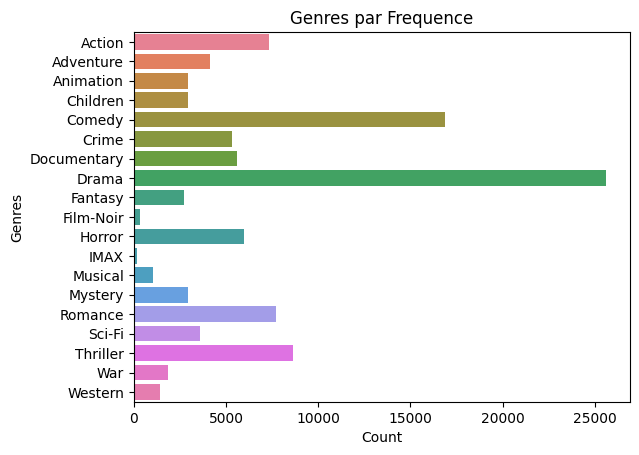

In [11]:
genres_count=genres_count.drop(genres_count[genres_count.Genres=='(no genres listed)'].index)
# Plotting avec sns.barplot
sns.barplot(data=genres_count, x='Count', y='Genres', hue="Genres")
plt.title("Genres par Frequence")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

Suppression des films dont le genre n'est pas indiqué

In [12]:
#suppression de (no genres listed)
data_movies_1 =data_movies.drop(data_movies[data_movies.genres=='(no genres listed)'].index)

In [13]:
#Nouveau Dataframe sans les films avec genre non listés
data_movies_1.to_csv('movies_1.csv',index=False)

Visualisation du dataset des ratings


In [18]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [21]:
data_ratings.shape

(25000095, 4)

Supprimer les utilisateurs ayant évalué moins de 5000 films (pour des raisons calculatoires)

In [22]:
users_participation_counts = data_ratings.userId.value_counts()
# Définir le seuil
seuil = 5000

# Filtrer les utilisateurs qui ont évalué au moins 5000 films
active_users = users_participation_counts[users_participation_counts >= seuil].index

In [23]:
# Filtrer les données d'origine
filtered_ratings = data_ratings[data_ratings['userId'].isin(active_users)]
# Vérifier le résultat
print(f"Nombre de lignes après filtrage : {filtered_ratings.shape[0]}")

Nombre de lignes après filtrage : 138974


In [26]:
filtered_ratings

,userId,movieId,rating,timestamp
3037025,20055,1,5.0,1160463838
3037026,20055,2,3.0,1160533952
3037027,20055,3,2.5,1163336461
3037028,20055,5,1.5,1163336723
3037029,20055,6,4.0,1160532816
...,...,...,...,...
21136067,137293,202253,3.0,1561243131
21136068,137293,202561,3.0,1561085428
21136069,137293,202575,3.5,1563311305
21136070,137293,203693,3.0,1563759849


In [27]:
#Dataframe de movies avec les genres non listes
data_movies_nogenres=data_movies.where(data_movies.genres=='(no genres listed)').dropna()
data_movies_nogenres

,movieId,title,genres
15881,83773.0,Away with Words (San tiao ren) (1999),(no genres listed)
16060,84768.0,Glitterbug (1994),(no genres listed)
16351,86493.0,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
16491,87061.0,Trails (Veredas) (1978),(no genres listed)
17404,91246.0,Milky Way (Tejút) (2007),(no genres listed)
...,...,...,...
62400,209101.0,Hua yang de nian hua (2001),(no genres listed)
62401,209103.0,Tsar Ivan the Terrible (1991),(no genres listed)
62407,209133.0,The Riot and the Dance (2018),(no genres listed)
62415,209151.0,Mao Zedong 1949 (2019),(no genres listed)


In [28]:
#Verifier les type de donnees que nous avons
data_movies_nogenres.dtypes

movieId    float64
title       object
genres      object
dtype: object

In [29]:
#Changer le type de donnees de movieid
data_movies_nogenres.movieId = data_movies_nogenres.movieId.astype(int)

In [30]:
#Merge data_movies_no_genres avec data_ratings pour avoir le nouveau data_ratings avec les films sans genre listes
new_data_ratings = filtered_ratings.merge(data_movies_nogenres, on='movieId', how='left')

# Display the resulting DataFrame
new_data_ratings

,userId,movieId,rating,timestamp,title,genres
0,20055,1,5.0,1160463838,NaN,NaN
1,20055,2,3.0,1160533952,NaN,NaN
2,20055,3,2.5,1163336461,NaN,NaN
3,20055,5,1.5,1163336723,NaN,NaN
4,20055,6,4.0,1160532816,NaN,NaN
...,...,...,...,...,...,...
138969,137293,202253,3.0,1561243131,NaN,NaN
138970,137293,202561,3.0,1561085428,NaN,NaN
138971,137293,202575,3.5,1563311305,NaN,NaN
138972,137293,203693,3.0,1563759849,NaN,NaN


In [31]:
#suppression  des lignes (no genres listed) dans ratings
data_ratings_1 =new_data_ratings.drop(new_data_ratings[new_data_ratings.genres=='(no genres listed)'].index)
#Suppression des colonnes 'title' et 'genres'
data_ratings_1=data_ratings_1.drop(columns=['title','genres'],axis=1)

In [32]:
#Verifier les types du dataframe ratings
data_ratings_1.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [35]:
#shape
data_ratings_1.shape

(136267, 4)

Standardisation des notes des évaluations

In [36]:
#Mapping des ratings
ratings_map= {5.5:5, 4.5: 4, 3.5:3, 2.5:2, 1.5:1, 0.5:1}

# Appliquer le mapping avec iterrows()
for index, row in data_ratings_1.iterrows():
  if row['rating'] in ratings_map:
    data_ratings_1.loc[index, 'rating'] = ratings_map[row['rating']]


In [37]:
#Changer le type de donnees de ratings
data_ratings_1.rating = data_ratings_1.rating.astype(int)

In [40]:
data_ratings_1

,userId,movieId,rating,timestamp
0,20055,1,5,1160463838
1,20055,2,3,1160533952
2,20055,3,2,1163336461
3,20055,5,1,1163336723
4,20055,6,4,1160532816
...,...,...,...,...
138969,137293,202253,3,1561243131
138970,137293,202561,3,1561085428
138971,137293,202575,3,1563311305
138972,137293,203693,3,1563759849


In [41]:
#Generer le fichier ratings1
data_ratings_1.to_csv("ratings_1.csv",index=False)

Construction de la matrice binaire de contenu C caractérisant chaque film

In [42]:
# Extraire tous les genres uniques
all_genres = set()
for genres_str in data_movies_1['genres']:
    all_genres.update(genres_str.split('|'))

# Trier les genres par ordre alphabètique
all_genres = sorted(all_genres)

# Créer la matrice de contenu binaire
content_matrix = pd.DataFrame(0, index=data_movies_1['movieId'], columns=all_genres)

# Remplir la matrice
for idx, row in data_movies_1.iterrows():
    movie_genres = row['genres'].split('|')
    content_matrix.loc[row['movieId'], movie_genres] = 1


In [45]:
content_matrix

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209155,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
209157,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209159,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Construction de la matrice de profil des utilisateurs 

In [46]:
data_ratings_1['userId']

0          20055
1          20055
2          20055
3          20055
4          20055
           ...  
138969    137293
138970    137293
138971    137293
138972    137293
138973    137293
Name: userId, Length: 136267, dtype: int64

In [47]:
user_profile = {}

for user_id, user_movies in data_ratings_1.groupby('userId'):
    profile_vector = (user_movies['rating'].values[:, None] *
                      content_matrix.loc[user_movies['movieId']].values).sum(axis=0)
    norm = np.linalg.norm(profile_vector)
    user_profile[user_id] = profile_vector / norm if norm > 0 else profile_vector

# Convertir le dictionnaire en DataFrame
user_profiles_df = pd.DataFrame.from_dict(user_profile, orient='index', columns=content_matrix.columns)
print(user_profiles_df)

          Action  Adventure  Animation  Children    Comedy     Crime  \
20055   0.187960   0.157359   0.050531  0.077208  0.434669  0.168091   
29803   0.305101   0.177734   0.043236  0.069088  0.438262  0.195452   
30879   0.201627   0.114488   0.007851  0.019671  0.641980  0.228718   
33844   0.183993   0.099806   0.015289  0.028857  0.359515  0.213644   
49403   0.308161   0.208424   0.117894  0.128763  0.567477  0.189116   
57548   0.334139   0.231327   0.105233  0.099459  0.453528  0.180852   
61010   0.241714   0.154041   0.045151  0.070084  0.472549  0.204269   
72315   0.145207   0.095821   0.066485  0.047843  0.371490  0.140970   
75309   0.254568   0.110906   0.028158  0.047696  0.384725  0.169233   
78849   0.262970   0.142081   0.003870  0.028103  0.453240  0.255875   
80974   0.178206   0.140623   0.030893  0.061508  0.466839  0.182016   
92046   0.156675   0.139096   0.054450  0.072151  0.491952  0.175356   
93855   0.275066   0.176433   0.065559  0.085215  0.539656  0.19

Diviser les données en 80% pour les données d'entraînement et 20% pour les données de test

In [48]:
# Mélanger les données
data_ratings_shuffled = data_ratings_1.sample(frac=1, random_state=42).reset_index(drop=True)

# Diviser les données (80 % pour les données d'entraînement et 20% pour les données de test)
split_index = int(len(data_ratings_shuffled) * 0.8)
ratings_apprentissage = data_ratings_shuffled[:split_index]
ratings_evaluation = data_ratings_shuffled[split_index:]

# Créer les fichiers ratings_apprentissage.csv et ratings_evaluation.csv qui contiennent respectivement les données d'entraînement
# et les données d'évaluation
ratings_apprentissage.to_csv("ratings_apprentissage.csv", index=False)
ratings_evaluation.to_csv("ratings_evaluation.csv", index=False)

# Afficher les tailles des ensembles
print(f"Taille de l'ensemble d'apprentissage : {len(ratings_apprentissage)}")
print(f"Taille de l'ensemble d'évaluation : {len(ratings_evaluation)}")

Taille de l'ensemble d'apprentissage : 109013
Taille de l'ensemble d'évaluation : 27254


Application de la combinaison "K-means + silhouette" pour déterminer le bon nombre de clusters et les résultats du clustering 

In [49]:
def effectuer_clustering(user_profiles_df):

    # Initialiser best_k à 2, cette valeur sera mise à jour si un autre k est trouvé comme optimal
    best_k = 2

    # Initialiser le score silhouette correspondant au clustering optimal
    best_silhouette = -1

    # Initialisation d'une liste qui contient les scores silhouette pour les différentes valeurs de k
    silhouette_scores = []

    for k in range (2,11):
            # Appliquer k-means clustering
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(user_profiles_df)

            # Calculer le score de silhouette
            silhouette_avg = silhouette_score(user_profiles_df, cluster_labels)
            silhouette_scores.append((k, silhouette_avg))

            # Chercher le k et le score silhouette correspondant au clustering optimal
            if silhouette_avg > best_silhouette:
                best_k = k
                best_silhouette = silhouette_avg
    return best_k, silhouette_scores

# Appel de la fonction avec la matrice user_profiles_df
best_k, silhouette_scores = effectuer_clustering(user_profiles_df)

print(f"Meilleur nombre de clusters : {best_k}")
print("Scores de silhouette pour chaque k :", silhouette_scores)

Meilleur nombre de clusters : 2
Scores de silhouette pour chaque k : [(2, np.float64(0.32103403775401357)), (3, np.float64(0.3131990902145277)), (4, np.float64(0.2639469983207576)), (5, np.float64(0.2474550645013966)), (6, np.float64(0.2855881223753658)), (7, np.float64(0.29245073561114243)), (8, np.float64(0.23363578086579484)), (9, np.float64(0.16831304349464424)), (10, np.float64(0.1648440799008041))]


In [50]:
# On roule le KMeans pour le k optimal trouvé
kmeans = KMeans(n_clusters=best_k, random_state=42)

# Ajout d'une colonne "cluster" à la matrice user_profiles_df qui indique le cluster à lequel appartient chaque utilisateur
user_profiles_df["cluster"] = kmeans.fit_predict(user_profiles_df)

In [51]:
user_profiles_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,cluster
20055,0.187960,0.157359,0.050531,0.077208,0.434669,0.168091,0.079783,0.736693,0.087326,0.027964,0.110016,0.015638,0.073651,0.085548,0.240883,0.101676,0.233095,0.082972,0.045196,1
29803,0.305101,0.177734,0.043236,0.069088,0.438262,0.195452,0.061399,0.651765,0.098729,0.006686,0.131935,0.030867,0.020392,0.082460,0.187986,0.155447,0.333739,0.056942,0.018609,0
30879,0.201627,0.114488,0.007851,0.019671,0.641980,0.228718,0.023122,0.573822,0.059272,0.012769,0.079029,0.008714,0.037012,0.085672,0.225784,0.103100,0.265903,0.018981,0.012424,0
33844,0.183993,0.099806,0.015289,0.028857,0.359515,0.213644,0.018995,0.746827,0.052220,0.018399,0.141966,0.013237,0.023363,0.106226,0.187435,0.076840,0.375201,0.062412,0.034350,1
49403,0.308161,0.208424,0.117894,0.128763,0.567477,0.189116,0.077871,0.503159,0.126333,0.006777,0.159835,0.034141,0.039383,0.089635,0.174284,0.190523,0.305476,0.037977,0.018797,0


In [52]:
def generer_recommendations(train_set, user_profiles_df, top_n=10):
    # Chercher les films les plus populaires dans chaque cluster
    train_set = train_set.merge(user_profiles_df["cluster"], how="left", left_on="userId", right_index=True)
    cluster_popularity = train_set.groupby(["cluster", "movieId"])["rating"].mean().reset_index()

    # Stocker les recommandations
    recommendations = {}

    for user_id, user_cluster in user_profiles_df["cluster"].items():
        # Chercher les films les plus populaires dans le cluster de l'utilisateur
        cluster_movies = cluster_popularity[cluster_popularity["cluster"] == user_cluster]
        cluster_movies = cluster_movies.sort_values(by="rating", ascending=False)

        # Eliminer les films déjà évalués par l'utilisateur
        user_movies = train_set[train_set["userId"] == user_id]["movieId"].unique()
        recommended_movies = cluster_movies[~cluster_movies["movieId"].isin(user_movies)]

        # Garder les top N recommandations (dans notre cas, top_n=10)
        recommendations[user_id] = recommended_movies["movieId"].head(top_n).tolist()

    return recommendations

In [53]:
# Charger les données d'apprentissage
train_set = pd.read_csv("ratings_apprentissage.csv")

# Faire des recommandations
recommendations = generer_recommendations(train_set, user_profiles_df)

# Évaluation du système de recommandation
def evaluation_systeme_recommandation(test_set, recommendations):
    predictions = []
    actuals = []

    for _, row in test_set.iterrows():
        user_id = row["userId"]
        movie_id = row["movieId"]
        actual_rating = row["rating"]

        # Vérifier si un film recommandé correspond à l'utilisateur
        if user_id in recommendations and movie_id in recommendations[user_id]:
            predicted_rating = train_set[train_set["movieId"] == movie_id]["rating"].mean()
            predictions.append(predicted_rating)
            actuals.append(actual_rating)

    # Calculer le RMSE
    rmse = mean_squared_error(actuals, predictions, squared=False)
    return rmse

# Charger les données d'évaluation
test_set = pd.read_csv("ratings_evaluation.csv")

# Évaluer le système de recommandation
rmse = evaluation_systeme_recommandation(test_set, recommendations)
print(f"RMSE du système de recommandation : {rmse:.4f}")

RMSE du système de recommandation : 1.1534


c:\Users\Pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
